In [1]:
#!pip install pyephem

import ephem
from astropy.coordinates import solar_system
from astropy import time
from astropy.coordinates import SkyCoord
import astroquery.heasarc

import astropy.units as u
import astropy.coordinates as coord
import numpy as np

import matplotlib as mpl
import matplotlib.pylab as plt

import pandas as pd
import io

import gzip

In [2]:
if False:
    # this is slow, 5-10min
    H = astroquery.heasarc.Heasarc()

    with astroquery.heasarc.Conf.server.set_temp('https://www.isdc.unige.ch/browse/w3query.pl'):
        R = H.query_object('Crab', mission='integral_rev3_scw', resultmax=1000000, radius="1000 deg", cache=False,
                           time="2001-01-01 .. 2021-01-01",
                           fields='All',
                           good_isgri=">1000",
                           scw_type="POINTING"

           )

    print("writing...")
    R.to_pandas().to_csv(open("archive.csv", "w"))
    
    R.sort('SCW_ID')
    R.to_pandas().to_csv("archive.csv", encoding='UTF_8')
else:
    R = pd.read_csv("archive.csv")

In [3]:
for c in R.columns:
    print(c)
    
    try:
        R[c] = R[c].astype(str)
    except:
        print("fail!")

Unnamed: 0
SCW_ID
SCW_VER
SCW_TYPE
RA_X
DEC_X
START_DATE
END_DATE
OBS_ID
OBS_TYPE
PS
PI_NAME
GOOD_SPI
GOOD_PICSIT
GOOD_ISGRI
GOOD_JEMX
GOOD_JEMX1
GOOD_JEMX2
GOOD_OMC
DSIZE
RA_Z
DEC_Z
POSANGLE
OBT_START
OBT_END
IJD_START
IJD_END
SPIMODE
IBISMODE
JMX1MODE
JMX2MODE
OMCMODE
EXP_ID
CREA_DT
ING_DT
Sun_ra
Sun_dec
Sun_distance_cm
Venus_ra
Venus_dec
Venus_distance_cm
Mars_ra
Mars_dec
Mars_distance_cm
Mercury_ra
Mercury_dec
Mercury_distance_cm
Jupiter_ra
Jupiter_dec
Jupiter_distance_cm
Saturn_ra
Saturn_dec
Saturn_distance_cm
Uranus_ra
Uranus_dec
Uranus_distance_cm
Neptune_ra
Neptune_dec
Neptune_distance_cm
Pluto_ra
Pluto_dec
Pluto_distance_cm


In [4]:
scx_coord = coord.SkyCoord(R['RA_X'], R['DEC_X'], unit="deg")

In [5]:
"total good ISGRI:", r['GOOD_ISGRI'].astype(float).sum()/1e6

NameError: name 'r' is not defined

In [6]:
def get_body_coord_pyephem(body_name):
    # this is faster than astropy, result is identical
    body = getattr(ephem, body_name)()

    body_ra = []
    body_dec = []
    for t1,t2 in zip(R['START_DATE'], R['END_DATE']):
        body.compute(t1) 
        body_ra.append(body.ra/np.pi*180)
        body_dec.append(body.dec/np.pi*180)
    
    return coord.SkyCoord(body_ra, body_dec, unit='deg')

In [7]:
def get_body_coord_astropy(body_name):
    return solar_system.get_body(body_name, 
                                 time.Time(R['IJD_START'].astype(float) + 51544, format="mjd"))


In [8]:
R['IJD_START'].max()

'7670.99508748996'

In [9]:
T_future_astropy = time.Time(
    R['IJD_START'].astype(float).max() + 51544 + np.linspace(0, 365*3, 365*3),
    format="mjd")
T_future = T_future_astropy.to_datetime()

def get_body_coord_astropy_future(body_name):
    return solar_system.get_body(body_name, 
                                 T_future_astropy)

In [10]:

def total_flux_sensivity(c, lim_deg=10):
    sep=c.separation(scx_coord).deg
    m = sep < lim_deg    
    
    isgri_sensitivity_25_80_keV_1sigma_2ks = 1e-8 * u.erg/u.cm**2/u.s * (1./2000.)

    sens = (c.distance.to(u.cm)[m]**2 * isgri_sensitivity_25_80_keV_1sigma_2ks * (R['GOOD_ISGRI'][m].astype(float)/200)**0.5).to(u.erg/u.s)

    sens_combined = np.sum((sens**-2))**-0.5 # weighed mean uncertainty

    return sens_combined
    

In [11]:
body_names = ['Venus', 'Sun', 'Mars', 'Mercury', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto']

==================================================Venus
found 0.174117 Ms in 85 pointings of Venus good ISGRI observations within 10 deg


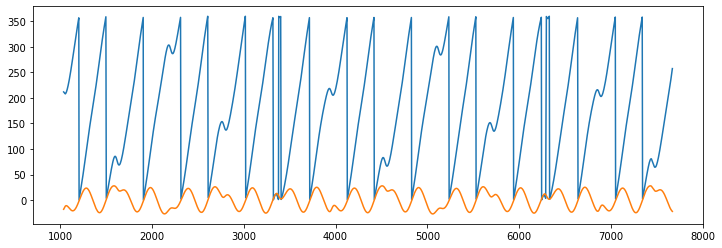

found 0.168514 Ms in 81 pointings of Venus good ISGRI observations within 10 deg


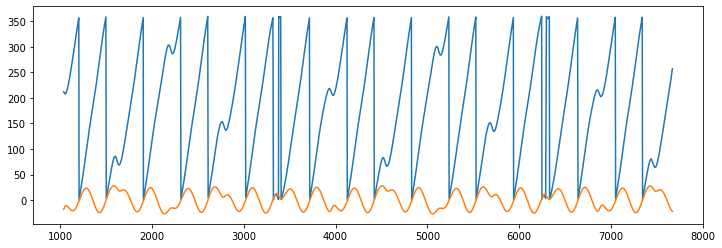

AttributeError: 'Series' object has no attribute 'to'

In [12]:
def find_body_in_fov(body_name, lim_deg=10, f=get_body_coord_pyephem, plot=True):
    c = f(body_name)

    sep=c.separation(scx_coord).deg
    m = sep < lim_deg
    on_isgri = np.sum(R['GOOD_ISGRI'].astype(float)[m])/1e6
    print(f"found {on_isgri} Ms in {np.sum(m)} pointings of {body_name} good ISGRI observations within {lim_deg} deg")
    
    if body_name == "Sun":
        if np.sum(m) == 0:
            print("Sun was not observed, which is good!")
        else:
            print("\033[31mwarning! sun was observed??\033[0m")
            #raise RuntimeError
    
    if plot:
        plt.figure(figsize=(12,4))

        plt.plot(
            R['IJD_START'][::100].astype(float),
            c.ra[::100],
        )
        plt.plot(
            R['IJD_START'][::100].astype(float),
            c.dec[::100],
        )

                
        
        plt.title('')

        plt.show()
    

    return c, m, on_isgri, np.sum(m)

fast_way = False

summary_by_body={}

for body_name in ['Venus', 'Sun', 'Mars', 'Mercury', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto']:
    D = {}
    summary_by_body[body_name] = D
    
    print(f"\033[41m{'='*100}\033[0m")
    print(f"\033[41m{'='*50}\033[1;42m{body_name}\033[0m")
    c, m, on_isgri, n_point = find_body_in_fov(body_name)
    if not fast_way:
        try:
            c, m, on_isgri, n_point = find_body_in_fov(body_name, f=get_body_coord_astropy)
            sens_combined = total_flux_sensivity(c)        
            print(f"total flux sensitivity to {body_name} is {sens_combined.to(u.erg/u.s).value:6.3g} erg/s")
            
            D["sensitivity_erg_s"] = sens_combined.to(u.erg/u.s).value            
            distance_cm = c.distance.cm
        except KeyError:
            print("failed to distance astropy!")
            distance_cm = np.inf
            
        D["on_isgri_Ms"] = on_isgri
        D["on_pointings"] = n_point
        R[f'{body_name}_ra'] = c.ra.deg
        R[f'{body_name}_dec'] = c.dec.deg
        R[f'{body_name}_distance_cm'] = distance_cm



In [307]:
#R.to_pandas().to_csv("archive-with-bodies.csv.gz", compression='gzip')

In [13]:
R = pd.read_csv("archive-with-bodies.csv.gz", compression='gzip')

In [14]:
import astropy.time as time

T = time.Time(R['IJD_START'].astype(float) + 51544, format="mjd").to_datetime()


In [15]:
Sun_coord = coord.SkyCoord(R["Sun_ra"], R["Sun_dec"], unit="deg")

In [16]:
Sun_coord_future = get_body_coord_astropy_future('Sun')

In [17]:
R[body_name+"_distance_cm"].astype(float)

0         4.069455e+12
1         4.117846e+12
2         4.120334e+12
3         4.122867e+12
4         4.125445e+12
              ...     
160548    2.332957e+13
160549    2.333077e+13
160550    2.333196e+13
160551    2.333316e+13
160552    2.333434e+13
Name: Venus_distance_cm, Length: 160553, dtype: float64

will plot
distance_cm [2.33343391e+13 2.33875387e+13 2.34401793e+13 ... 1.74915341e+13
 1.75863027e+13 1.76806479e+13]
isgri_sensitivity_25_80_keV_1sigma_2ks 5e-11 erg / (cm2 s)


NameError: name 'reference_object_erg_s' is not defined

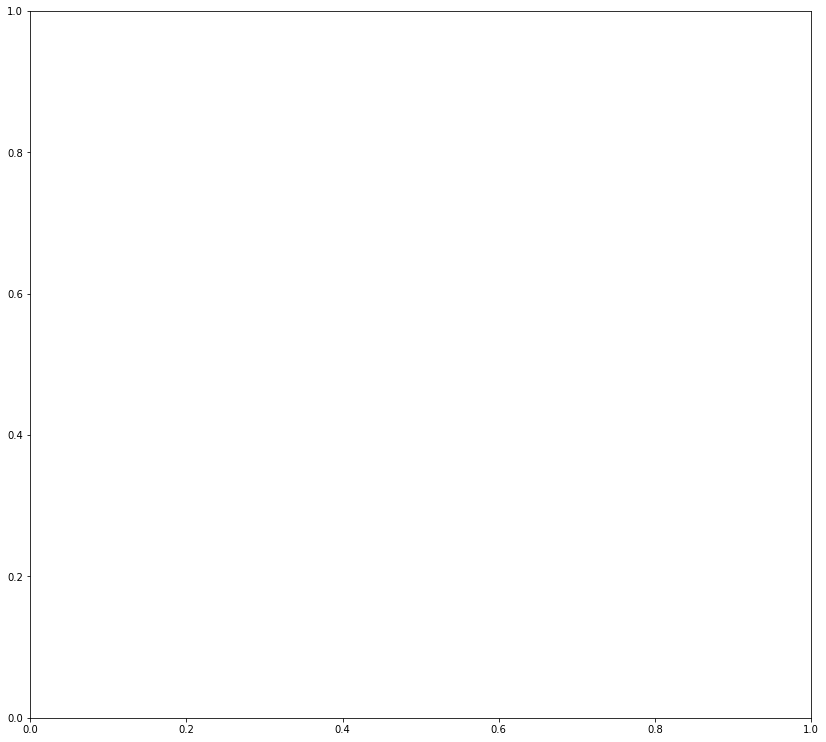

In [20]:
ax2=None

import matplotlib.font_manager as font_manager
font_prop = font_manager.FontProperties(size=16)
font_prop14 = font_manager.FontProperties(size=14)


#plt.figure(figsize=(14,10))
f, ax = plt.subplots(1,1,figsize=(14,13))

for body_name in body_names:
    if body_name in ['Sun', 'Mercury', 'Pluto']:
        continue
        
    color = None
    label = body_name
        
    C_future = get_body_coord_astropy_future(body_name)
    
    for _T, distance_cm, _ra, _dec, Sun_c, _ls in [
        (T_future, C_future.distance.cm, C_future.ra.deg, C_future.dec.deg, Sun_coord_future, "--"),
        (T, np.array(R[body_name+"_distance_cm"].astype(float)), R[body_name + "_ra"].astype(float), R[body_name + "_dec"].astype(float), Sun_coord, None),
    ]:
        print("will plot")
        
        print("distance_cm", distance_cm)
        print("isgri_sensitivity_25_80_keV_1sigma_2ks", isgri_sensitivity_25_80_keV_1sigma_2ks)

        sens_ecs_1scw = ((distance_cm*u.cm)**2 * isgri_sensitivity_25_80_keV_1sigma_2ks).to(u.erg/u.s)
        sens_ecs_1week = sens_ecs_1scw * (2000. / (24*3600*7 * 0.8) )**0.5
        sens_ecs = sens_ecs_1week

        isens_ecs = reference_object_erg_s.get(body_name, 1e19) / sens_ecs_1week

        p = ax.plot(
            _T[::10],
            isens_ecs[::10],
            #label=label,
            ls=_ls or ":",
            alpha=0.7,
            color=color,            
        )
        
        color = p[0].get_color()

        print("convertting coord", len(_ra))
        C = coord.SkyCoord(_ra, _dec, unit="deg")
        print("distance..")
        
        if len(C) == len(scx_coord):
            D_deg = C.separation(scx_coord).deg
            R[body_name+"_from_sc_x_deg"] = D_deg
            
        print("done!")

        Sun_angle_deg = Sun_c.separation(C).deg
        m_sun_angle = Sun_angle_deg > (90 - 40 - 5) # 5 for off-axis
        m_sun_angle &= Sun_angle_deg < (90 + 40 + 5)


        #label = body_name
        for m_segment in split_segments((time.Time(_T).mjd - 51544)[m_sun_angle].astype(float)):
            ax.plot(
                _T[m_sun_angle][m_segment],
                isens_ecs[m_sun_angle][m_segment],
                lw=3,
                c=color,
                label=label,
                ls=_ls,
            )
            label = None
    
    
    m = R['GOOD_ISGRI'].astype(float) > 1000
    m &= D_deg < 10
    
    ax.scatter(
        T[m],
        isens_ecs[m],
        c=color,
        s=100,
        marker="o",
        #label=body_name,
    )
    
    #ax.axhline(
    #    reference_object_erg_s.get(body_name, 1e19),
    #    c=p[0].get_color(),
    #)

    if ax2 is not None:
        p = ax2.plot(
            T[::100],
            Sun_angle_deg[::100],
         #   label=body_name,
            c=color,
        )
    
ax.legend()
    
ax.semilogy()

ax.set_xlim([T[-20000],time.Time("2024-01-01").to_datetime()])


ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)


ax.grid()

ax.set_title("Solid lines: INTEGRAL can point; big dots: existing pointings < 10 deg", font=font_prop)

ax.axhspan(3,12, alpha=0.05, color='g')

ax.axvspan(
    time.Time("2021-01-01").to_datetime(), 
    time.Time("2022-01-01").to_datetime(), 
    color='red', alpha=0.1)
ax.axvspan(
    time.Time("2022-01-01").to_datetime(), 
    time.Time("2024-01-01").to_datetime(), 
    color='yellow', alpha=0.1)

ax.set_ylim([0.005, 10])

ax.set_xlabel("Date", fontproperties=font_prop)
ax.set_ylabel("\"expected\" S/N in One Week (0.5 Ms) ISGRI observation\nfor \"typical\" body X-ray Luminosity", fontproperties=font_prop)


ax.set_xlim([
    time.Time("2002-11-01").to_datetime(),
    time.Time("2024-01-01").to_datetime()])

plt.savefig("sensitivity-by-time.png")

ax.set_xlim([
    time.Time("2015-11-01").to_datetime(),
    time.Time("2024-01-01").to_datetime()])

plt.savefig("sensitivity-by-time-recent.png")

ax.set_xlim([
    time.Time("2021-11-01").to_datetime(),
    time.Time("2023-01-01").to_datetime()])

plt.savefig("sensitivity-by-time-plan.png")

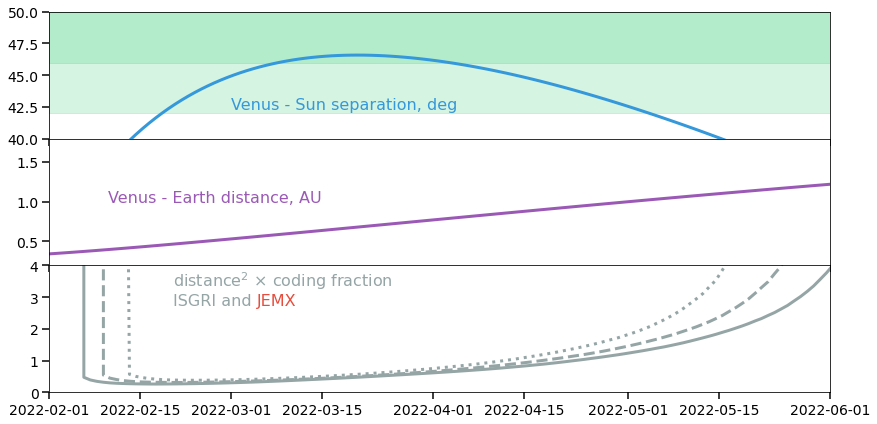

In [46]:
import seaborn
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

f, (ax1,ax2,ax3) = plt.subplots(3, 1, figsize=(14,7), sharex=True)

C = get_body_coord_astropy_future('Venus')

#ax1.grid(True)
ax1.plot(
    T_future,
    Sun_coord_future.separation(C).deg,
    lw=3,
    c=flatui[1]
)
ax1.set_ylim([40,50])

ax1.text(time.Time("2022-03-01").to_datetime(), 42.3,
         "Venus - Sun separation, deg",
         c=flatui[1],
         font_properties=font_prop)

ax1.axhspan(50, 55, color=flatui[-1], alpha=0.2)
ax1.axhspan(50 - 4, 55, color=flatui[-1], alpha=0.2)
ax1.axhspan(50 - 8, 55, color=flatui[-1], alpha=0.2)

#ax2.grid(True)
ax2.plot(
    T_future,
    C.distance.to(u.AU).value,
    lw=3,
    c=flatui[0]
)

ax2.text(time.Time("2022-02-10").to_datetime(), 1.,
         "Venus - Earth distance, AU",
         c=flatui[0],
         font_properties=font_prop)

plt.subplots_adjust(hspace=0)

#ax3.grid()

for dither_offset, ls in [
                            (0, '-'), 
                            (2, '--'), 
                            (4, ':')
                        ]:
    plt.plot(
        T_future,
        C.distance.to(u.AU).value**2 * sensitivity_isgri_vs_off_scx(50 + dither_offset - Sun_coord_future.separation(C).deg),
        lw=3,
        c=flatui[2],
        ls=ls,
    )

#     plt.plot(
#         T_future,
#         C.distance.to(u.AU).value**2 * sensitivity_jemx_vs_off_scx(50 + dither_offset- Sun_coord_future.separation(C).deg) ,
#         lw=3,
#         c=flatui[3],
#         ls=ls,
#     )

#10 for 5x5
#4 for hex

plt.ylim([0, 4])

for ax in ax1,ax2, ax3:
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(which='major', width=1.5, length=7)
    ax.tick_params(which='minor', width=1.5, length=4)

plt.xlim([time.Time("2022-02-01").to_datetime(),time.Time("2022-06-01").to_datetime()])


ax3.text(time.Time("2022-02-20").to_datetime(), 2.75,
         "distance$^2$ $\\times$ coding fraction\nISGRI and",
         c=flatui[2],
         font_properties=font_prop)

ax3.text(time.Time("2022-03-05").to_datetime(), 2.75,
         "JEMX",
         c=flatui[3],
         font_properties=font_prop)


plt.savefig("venus-poiting-optimization.png")

Text(0.5, 1.0, 'Venus coords, 2022-03-01 - 2022-04-14')

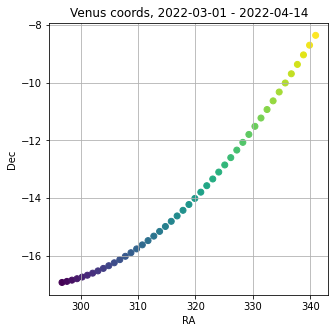

In [77]:
plt.figure(figsize=(5,5))

plt.grid()

plt.xlabel("RA")
plt.ylabel("Dec")

m = T_future > time.Time('2022-03-01')
m &= T_future < time.Time('2022-04-15')

plt.scatter(
    C[m].ra.deg,
    C[m].dec.deg,
    c=time.Time(T_future).mjd[m]
)

plt.title(f"Venus coords, {str(time.Time(T_future)[m][0])[:10]} - {str(time.Time(T_future)[m][-1])[:10]}")

<ipython-input-248-f56e49632e69>:17: RuntimeWarning: invalid value encountered in true_divide
  step_deg*60/(dt*24*3600/2000),
/home/savchenk/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/savchenk/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
<ipython-input-248-f56e49632e69>:17: RuntimeWarning: invalid value encountered in true_divide
  step_deg*60/(dt*24*3600/2000),
/home/savchenk/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/savchenk/.pyenv/versions/3.8.6/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


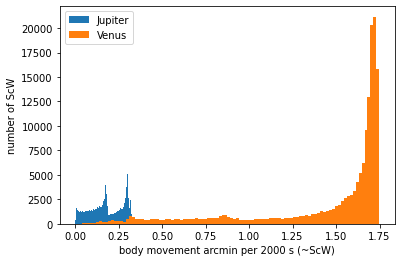

In [248]:
plt.figure()

for body_name in "Jupiter", "Venus":
    m = R[body_name + '_from_sc_x_deg'] < 1000

    c = SkyCoord(
        R[m][body_name + '_ra'],
        R[m][body_name + '_dec'],
        unit='deg'
    )

    step_deg = c[:-1].separation(c[1:]).deg
    t = np.array(R[m]['IJD_START'].astype(float))
    dt = t[1:] - t[:-1]

    plt.hist(    
        step_deg*60/(dt*24*3600/2000),
        100,
        label=body_name,
    )
    
plt.legend()
    
plt.xlabel('body movement arcmin per 2000 s (~ScW)')
plt.ylabel("number of ScW")

plt.savefig("itra-fov-body-movement.png")

In [29]:
R

,Unnamed: 0,SCW_ID,SCW_VER,SCW_TYPE,RA_X,DEC_X,START_DATE,END_DATE,OBS_ID,OBS_TYPE,...,Neptune_distance_cm,Pluto_ra,Pluto_dec,Pluto_distance_cm,Venus_from_sc_x_deg,Mars_from_sc_x_deg,Jupiter_from_sc_x_deg,Saturn_from_sc_x_deg,Uranus_from_sc_x_deg,Neptune_from_sc_x_deg
0,0,752000030,1,POINTING,149.840576,-0.982139,2002-11-04 03:21:48,2002-11-04 05:51:48,...,,...,4.506940e+14,255.939451,-13.447897,inf,62.971269,41.983956,20.280395,64.072893,164.885444,153.098872
1,1,853000010,1,POINTING,149.840500,-0.982444,2002-11-06 19:56:20,2002-11-06 22:26:20,...,,...,4.513841e+14,256.028571,-13.467955,inf,61.628555,43.601798,20.104897,64.188811,164.887883,153.119665
2,2,853000020,1,POINTING,149.840454,-0.982611,2002-11-06 22:26:20,2002-11-07 00:56:20,...,,...,4.514107e+14,256.032067,-13.468724,inf,61.579766,43.664602,20.098546,64.193555,164.887892,153.120459
3,3,853000030,1,POINTING,149.840454,-0.982639,2002-11-07 00:56:20,2002-11-07 03:26:20,...,,...,4.514374e+14,256.035566,-13.469493,inf,61.531250,43.727383,20.092123,64.198297,164.888035,153.121328
4,4,853000040,1,POINTING,149.840500,-0.982750,2002-11-07 03:26:20,2002-11-07 05:56:20,...,,...,4.514640e+14,256.039068,-13.470261,inf,61.482938,43.790121,20.085820,64.203134,164.888093,153.122110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160548,160548,231500210010,1,POINTING,4.354625,59.149807,2020-12-31 21:43:24,2020-12-31 22:13:20,17200040123 ...,GENERAL,...,4.530649e+14,296.304932,-22.450363,inf,116.823943,50.318156,92.881281,93.533241,51.003205,65.883253
160549,160549,231500220010,1,POINTING,2.231208,61.046001,2020-12-31 22:15:35,2020-12-31 22:45:32,17200040123 ...,GENERAL,...,4.530703e+14,296.305713,-22.450265,inf,115.742010,52.486723,93.164473,93.781541,53.139358,67.442583
160550,160550,231500230010,1,POINTING,359.825073,62.902916,2020-12-31 22:47:47,2020-12-31 23:17:44,17200040123 ...,GENERAL,...,4.530756e+14,296.306494,-22.450166,inf,114.625093,54.657433,93.437015,94.018089,55.280850,69.015275
160551,160551,231500240010,1,POINTING,357.112122,64.710777,2020-12-31 23:19:58,2020-12-31 23:49:55,17200040123 ...,GENERAL,...,4.530810e+14,296.307275,-22.450067,inf,113.488181,56.822755,93.707810,94.251989,57.417876,70.601186


In [351]:
import time

import logging
logging.basicConfig(level='INFO')
logging.getLogger("oda_api").setLevel('INFO')

import oda_api.api


def get_oda(version="1.3"):
    return oda_api.api.DispatcherAPI(url={
                                "1.3": "http://in.internal.odahub.io/staging-1-3/dispatcher",
                                "1.2": "http://in.internal.odahub.io/staging-1.2/dispatcher",
                            }[version],
#                          cookies={
#                              "_oauth2_proxy": subprocess.check_output(["pass", "_oauth2_proxy"]).decode().strip()
#                          },
                          wait=True,
                         )

oda = get_oda()

isgri_image = oda.get_product(
               instrument='isgri', 
               product='isgri_image',    
               E1_keV=25,
               E2_keV=80,
               osa_version="OSA10.2",
               scw_list="066500220010.001",
            )

jemx_image = get_oda("1.2").get_product(
               instrument='jemx', 
               product='jemx_image',    
               E1_keV=25,
               E2_keV=80,
               osa_version="OSA10.2",
               scw_list="066500220010.001",
            )

2021-03-27 10:16:45 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi.progress[1743133] INFO - waiting for remote response (since 2021-03-27 10:16:45), please wait for http://in.internal.odahub.io/staging-1-3/dispatcher/run_analysis
2021-03-27 10:16:46 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi[1743133] INFO 
... query status prepared => submitted
2021-03-27 10:16:46 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi[1743133] INFO ... assigned job id: 9440d6dcbf681358
 | the job is working remotely, please wait status=submitted job_id=9440d6dc in 0 messages since 0 seconds (0.29/0.29); in 0 SCW so far; nodes (0): 0 computed 0 restored
2021-03-27 10:16:47 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi.progress[1743133] INFO - waiting for remote response (since 2021-03-27 10:16:47), please wait for http://in.internal.odahub.io/staging-1-3/dispatcher/run_analysis
 / the job is working remotely, please wait status=submitted job_id=9440d6dc in 1 messages since 1 seconds (0.

2021-03-27 10:17:25 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi.progress[1743133] INFO - waiting for remote response (since 2021-03-27 10:17:25), please wait for http://in.internal.odahub.io/staging-1.2/dispatcher/run_analysis
 / the job is working remotely, please wait status=progress job_id=73631275 in 4 messages since 26 seconds (1.7/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
2021-03-27 10:17:26 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi.progress[1743133] INFO - waiting for remote response (since 2021-03-27 10:17:26), please wait for http://in.internal.odahub.io/staging-1.2/dispatcher/run_analysis
 - the job is working remotely, please wait status=progress job_id=73631275 in 4 messages since 27 seconds (1.6/16); in 0 SCW so far; nodes (1): 0 computed 0 restored
2021-03-27 10:17:27 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi.progress[1743133] INFO - waiting for remote response (since 2021-03-27 10:17:27), please wait for http://in.internal.odahub.

 / the job is working remotely, please wait status=progress job_id=73631275 in 10 messages since 49 seconds (0.66/16); in 1 SCW so far; nodes (2): 0 computed 0 restored
2021-03-27 10:17:48 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi.progress[1743133] INFO - waiting for remote response (since 2021-03-27 10:17:48), please wait for http://in.internal.odahub.io/staging-1.2/dispatcher/run_analysis
 - the job is working remotely, please wait status=progress job_id=73631275 in 13 messages since 50 seconds (0.64/16); in 1 SCW so far; nodes (2): 0 computed 1 restored
2021-03-27 10:17:49 savchenk-NG-VN7-793G-79EG oda_api.api.dispatcherapi.progress[1743133] INFO - waiting for remote response (since 2021-03-27 10:17:49), please wait for http://in.internal.odahub.io/staging-1.2/dispatcher/run_analysis
 \ the job is working remotely, please wait status=progress job_id=73631275 in 13 messages since 51 seconds (0.62/16); in 1 SCW so far; nodes (2): 0 computed 1 restored
2021-03-27 10:17:51 sav

In [40]:
import astropy.io.fits as fits
from astropy import wcs
import numpy as np


jemx_image = fits.open("/mnt/sshfs/isdc/unsaved/astro/savchenk/data/reduced/ddcache/byscw/2077/207700740010.000/jemx_image.v2.2.1/JEMX.v0.jmx1/5cf19168/jmx1_sky_ima.fits.gz")[2]
jemx_var = jemx_image.data

In [41]:

jemx_wcs = wcs.WCS(jemx_image.header)
jemx_wcs.low_level_wcs

jemx_deg_per_pix = np.linalg.eigvals(jemx_wcs.wcs.cd)[0]

In [42]:
jemx_deg_per_pix

j_i, j_j = np.meshgrid(np.arange(jemx_var.data.shape[0]), np.arange(jemx_var.data.shape[1]))

In [43]:
import scipy as sp
import scipy.ndimage as ndimage

jemx_var_sm = ndimage.filters.gaussian_filter(jemx_var, 1)

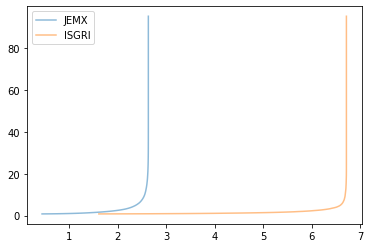

In [44]:
plt.figure()

for n, vr, dpp in ("JEMX", jemx_var, jemx_deg_per_pix), ("ISGRI", isgri_var, isgri_deg_per_pix):
    h = np.histogram(
        vr.flatten()**0.5/np.nanquantile(vr.flatten()**0.5, 0.5), 
        #np.linspace(0.9, 100, 100), 
        np.logspace(-0.1, 2, 100), 
     #   weights=np.ones_like(vr.flatten())*dpp**2,
    )
        
    plt.plot(
        (np.cumsum(h[0])*dpp**2)**0.5/np.pi,
        h[1][:-1],
        
        alpha=0.5,
        label=n,
    )
    
    
plt.legend()
#plt.semilogx()



In [531]:
np.nanquantile(jemx_var.flatten(), 0.01)

6.041411744206471e-09

In [27]:
plt.figure(figsize=(10,10))

#isgri_var = isgri_image.mosaic_image_0_mosaic.to_fits_hdu_list()[3].data

j_i, j_j = np.meshgrid(np.arange(jemx_var.data.shape[0]), np.arange(jemx_var.data.shape[1]))

plt.contourf(
    (j_i - np.mean(j_i)) * jemx_deg_per_pix,
    (j_j - np.mean(j_j)) * jemx_deg_per_pix,
    (jemx_var_sm/np.nanmin(jemx_var_sm))**0.5,
    levels=(1, 1/0.5, 1/0.25, 1/0.1)
)

deg_from_scx = (((j_i - np.mean(j_i)) * jemx_deg_per_pix)**2 + ((j_j - np.mean(j_j)) * jemx_deg_per_pix)**2)**0.5

plt.figure()

_x = np.linspace(0, 20, 100)
x = []
y = []

normed_var = jemx_var_sm/np.nanmin(jemx_var_sm) / 1.2

for x1, x2 in zip(_x[:-1], _x[1:]):
    m = (deg_from_scx.flatten() > x1) & (deg_from_scx.flatten()<=x2)
    y.append(normed_var.flatten()[m].mean()**0.5)
    x.append((x1+x2)/2.)
    
plt.scatter(
    deg_from_scx.flatten(),
    normed_var.flatten()**0.5,
)

deg_off_scx = np.array(x)
sensitivity_jemx_vs_off_scx = interp1d(x, np.array(y), bounds_error=False)


plt.plot(deg_off_scx, sensitivity_jemx_vs_off_scx(deg_off_scx), lw=3, c='r')
plt.plot(x, np.array(y)*0 + 1, lw=3, c='g')

plt.ylim([0,10])



NameError: name 'jemx_var_sm' is not defined

<Figure size 720x720 with 0 Axes>

In [494]:
isgri_image = fits.open("/mnt/sshfs/isdc/unsaved/astro/savchenk/data/reduced/ddcache/byscw/2077/207700740010.000/ii_skyimage.v2/3d87cb36/isgri_sky_ima.fits.gz")[3]

isgri_image.data.max()

29014.041

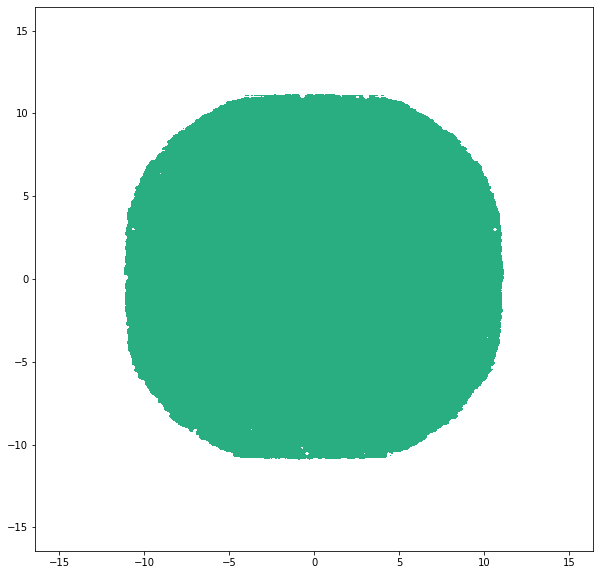

In [35]:
plt.figure(figsize=(10,10))

isgri_image = fits.open("/mnt/sshfs/isdc/unsaved/astro/savchenk/data/reduced/ddcache/byscw/1987/198700350010.001/ii_skyimage.v2/46b48a41/isgri_sky_ima.fits.gz")[3]
isgri_var = isgri_image.data[:,:]

isgri_var[np.isnan(isgri_var)] = 1e9
isgri_var[isgri_var == 0] = 1e9

isgri_wcs = wcs.WCS(isgri_image.header)
isgri_wcs.low_level_wcs

isgri_deg_per_pix = np.linalg.eigvals(isgri_wcs.wcs.cd)[0]

i_i, i_j = np.meshgrid(np.arange(isgri_var.data.shape[0]), np.arange(isgri_var.data.shape[1]))


plt.contourf(
    (i_i - np.mean(i_i)) * isgri_deg_per_pix,
    (i_j - np.mean(i_j)) * isgri_deg_per_pix,
    (isgri_var/np.nanmin(isgri_var))**0.5,
    levels=(0, 0.5, 2),
    #levels=(0, 0.5, 1., 1/0.5, 1/0.25, 1/0.1)
)


In [36]:
from scipy.interpolate import interp1d

NameError: name 'sensitivity_vs_off_scx' is not defined

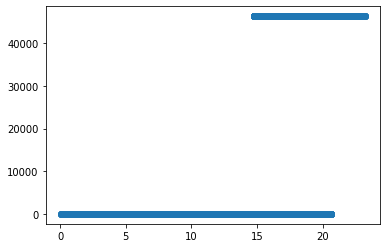

In [38]:
deg_from_scx = (((i_i - np.mean(i_i)) * isgri_deg_per_pix)**2 + ((i_j - np.mean(i_j)) * isgri_deg_per_pix)**2)**0.5

plt.figure()

_x = np.linspace(0, 20, 100)
x = []
y = []

normed_var = isgri_var/np.nanmin(isgri_var) / 1.2

for x1, x2 in zip(_x[:-1], _x[1:]):
    m = (deg_from_scx.flatten() > x1) & (deg_from_scx.flatten()<=x2)
    y.append(normed_var.flatten()[m].mean()**0.5)
    x.append((x1+x2)/2.)
    
plt.scatter(
    deg_from_scx.flatten(),
    normed_var.flatten()**0.5,
)

deg_off_scx = np.array(x)
sensitivity_isgri_vs_off_scx = interp1d(x, np.array(y), bounds_error=False)


plt.plot(deg_off_scx, sensitivity_vs_off_scx(deg_off_scx), lw=3, c='r')
plt.plot(x, np.array(y)*0 + 1, lw=3, c='g')

plt.ylim([0,10])


In [496]:
#(isgri_var/np.nanmin(isgri_var))**0.5

<ipython-input-496-6b1937d1eedf>:1: RuntimeWarning: divide by zero encountered in true_divide
  (isgri_var/np.nanmin(isgri_var))**0.5
<ipython-input-496-6b1937d1eedf>:1: RuntimeWarning: invalid value encountered in true_divide
  (isgri_var/np.nanmin(isgri_var))**0.5


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [498]:
np.nanmax(isgri_var)

29014.041

In [469]:
isgri_var.nanmax()

AttributeError: 'numpy.ndarray' object has no attribute 'nanmax'

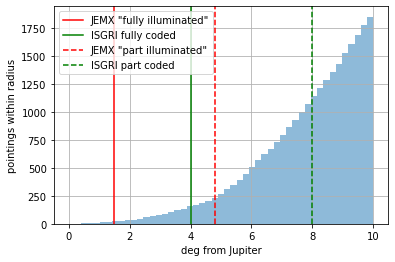

In [31]:
plt.figure()

plt.hist(
    R['Jupiter_from_sc_x_deg'], np.linspace(0, 10), cumulative=1, alpha=0.5)

plt.ylabel('pointings within radius')

plt

plt.axvline(3/2., label='JEMX "fully illuminated"', c='r')
plt.axvline(8./2., label='ISGRI fully coded', c='g')

plt.axvline(4.8, label='JEMX "part illuminated"', c='r', ls='--')
plt.axvline(8., label='ISGRI part coded', c='g', ls='--')


plt.grid()

plt.legend()

plt.xlabel("deg from Jupiter")

plt.savefig("jupiter-pointings.png")

In [264]:
R[R['Jupiter_from_sc_x_deg'] < 0.5]

,Unnamed: 0,SCW_ID,SCW_VER,SCW_TYPE,RA_X,DEC_X,START_DATE,END_DATE,OBS_ID,OBS_TYPE,...,Neptune_distance_cm,Pluto_ra,Pluto_dec,Pluto_distance_cm,Venus_from_sc_x_deg,Mars_from_sc_x_deg,Jupiter_from_sc_x_deg,Saturn_from_sc_x_deg,Uranus_from_sc_x_deg,Neptune_from_sc_x_deg
23364,23364,32100080010,1,POINTING,188.441177,-1.924306,2005-05-30 22:02:19,2005-05-30 22:37:02,03999150001 ...,GCDE,...,443833056905342.3,263.3898576528224,-14.984057360137609,inf,103.106886,162.839829,0.415057,74.150501,152.076445,128.973614
47930,47930,68000090010,1,POINTING,294.163788,-21.377695000000003,2008-05-08 15:09:54,2008-05-08 16:08:00,05200260004 ...,GENERAL,...,450659335464671.2,270.85097639091566,-17.021424214009894,inf,107.406619,172.901638,0.290940,140.771870,59.179728,31.645304
146377,146377,207800120010,1,POINTING,263.723236,-23.071832999999998,2019-04-11 11:08:50,2019-04-11 11:42:11,16200230012 ...,GENERAL,...,460236811287725.8,294.98716131029215,-21.716596525681897,inf,84.378195,162.861495,0.419098,25.746776,127.380971,82.959784


In [270]:
h0 = np.histogram(
    SkyCoord(R['RA_X'], R['DEC_X'], unit='deg').separation(SkyCoord(10,20, unit='deg')).deg, np.linspace(0, 10))


<ipython-input-272-74c5d64f4fbf>:10: RuntimeWarning: invalid value encountered in true_divide
  (np.cumsum(h[0]) - np.cumsum(h[0])**0.5) / h[1][:-1]**2,
<ipython-input-272-74c5d64f4fbf>:11: RuntimeWarning: invalid value encountered in true_divide
  (np.cumsum(h[0]) + np.cumsum(h[0])**0.5) / h[1][:-1]**2,
<ipython-input-272-74c5d64f4fbf>:19: RuntimeWarning: invalid value encountered in true_divide
  100*(np.cumsum(h0[0]) - np.cumsum(h0[0])**0.5) / h0[1][:-1]**2,
<ipython-input-272-74c5d64f4fbf>:20: RuntimeWarning: invalid value encountered in true_divide
  100*(np.cumsum(h0[0]) + np.cumsum(h0[0])**0.5) / h0[1][:-1]**2,


Text(0.5, 0, 'deg from Jupiter')

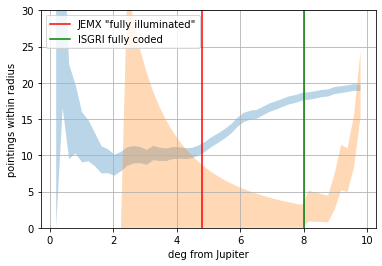

In [272]:
plt.figure()

h = np.histogram(
    R['Jupiter_from_sc_x_deg'], np.linspace(0, 10))

plt.ylabel('pointings within radius')

plt.fill_between(
    h[1][:-1],
    (np.cumsum(h[0]) - np.cumsum(h[0])**0.5) / h[1][:-1]**2,
    (np.cumsum(h[0]) + np.cumsum(h[0])**0.5) / h[1][:-1]**2,
    alpha=0.3
)



plt.ylim([0,30])

plt.axvline(4.8, label='JEMX "fully illuminated"', c='r')
plt.axvline(8., label='ISGRI fully coded', c='g')

plt.grid()

plt.legend()

plt.xlabel("deg from Jupiter")


In [19]:
isgri_sensitivity_25_80_keV_1sigma_2ks = 1e-8 * u.erg/u.cm**2/u.s * (1./200.) # 200 sigma in a pointing


def total_sensitivity(body_name, lim_deg=10):
    sep = R[body_name+"_from_sc_x_deg"].astype(float)
    distance_cm = R[body_name+"_distance_cm"].astype(float)
    m = sep < lim_deg    
    
    sens = np.array(((distance_cm[m] * u.cm)**2 * isgri_sensitivity_25_80_keV_1sigma_2ks * (R['GOOD_ISGRI'][m].astype(float)/2000)**0.5)).to(u.erg/u.s)

    sens_combined = np.sum((sens**-2))**-0.5 # weighed mean uncertainty

    return dict(
        lum_sens_total=sens_combined,
        lum_reference=reference_object_erg_s[body_name]*u.erg/u.s,
    )
        
    
print(total_sensitivity('Jupiter'))
print(total_sensitivity('Venus'))


AttributeError: 'numpy.ndarray' object has no attribute 'to'

In [29]:
# https://arxiv.org/pdf/1012.1088.pdf claims Venus X-ray luminosity could be :

(55*u.MW).to(u.erg/u.s)

# they also claim that only Chandra could do it. Of course, INTEGRAL can also! Even if not formally. But actually she already did it.

<Quantity 5.5e+14 erg / s>

In [763]:
# heasarc claims

reference_object_erg_s['Venus']*u.erg/u.s 

<Quantity 5.5e+14 erg / s>

In [789]:
R['SCW_ID'][R['Venus_from_sc_x_deg']<10]

022500150010
036900690010
036900700010
036900710010
037000660010
037000670010
037000680010
037000690010
037000700010
037000710010
037000720010


In [27]:
plt.figure(figsize=(12,10))

def split_segments(ijd, limit=60):
    if len(ijd) == 0:
        return []
    
    d_ijd = ijd[1:] - ijd[:-1]
    
    m_change_points = d_ijd > limit
    
    change_points = [ijd[0]] + list(ijd[:-1][m_change_points]) + [ijd[-1]]
    
    segments = []
    
    for i1,i2 in zip(change_points[:-1], change_points[1:]):
        segments.append(
            (ijd > i1) & (ijd < i2)
        )
    
    return segments
    
for m_segment in split_segments(R['IJD_START'][m_sun_angle].astype(float)):
    plt.plot(
        T[m_sun_angle][m_segment],
        R['Sun_distance_cm'][m_sun_angle][m_segment],
        lw=3,
        c='r'
    )

IndexError: Boolean index has wrong length: 1095 instead of 160553

<Figure size 864x720 with 0 Axes>

In [ ]:
# jupiter is best but has tons of observations

In [ ]:
# venus has no MF, but
# despite what is claimed, INTEGRAL can too
# https://arxiv.org/pdf/1012.1088.pdf

# if there is a flare when observation is possible, it would be nice to observe for a week, could be detection

2021-03-24 19:54:15 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5041.5211700300997109/UTC


5037.8197997775305 5044.493882091212


2021-03-24 19:54:15 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5044.4926764766796623/UTC
2021-03-24 19:54:15 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5041.5211700300997109/SCWID
2021-03-24 19:54:16 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5044.4926764766796623/SCWID
2021-03-24 19:54:18 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5037.8197997775305339/UTC
2021-03-24 19:54:18 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5044.4938820912120718/UTC


2013-10-16T19:39:23.516
2013-10-23T11:50:04.228


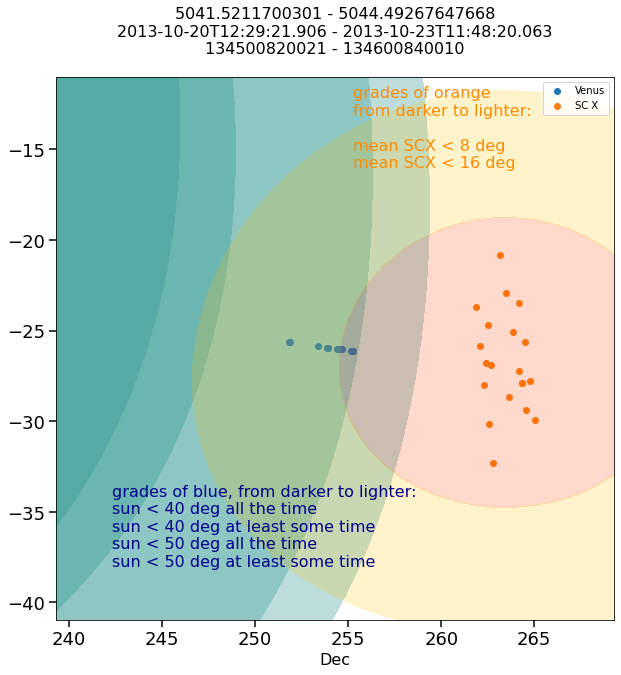

In [276]:
#from matplotlib import cmap 
plt.figure(figsize=(10,10))

#Venus
#C_future = get_body_coord_astropy_future(body_name)

m = R.Venus_from_sc_x_deg < 10

h = np.histogram(R['IJD_START'][m].astype(float), np.linspace(1000, 7000, 900))
i = h[0].argsort()[-2]

print(h[1][i], h[1][i+1])

ijd = R['IJD_START'][m].astype(float)

m &= ijd > h[1][i]
m &= ijd < h[1][i+1]

ra, dec= R.Venus_ra[m].astype(float),  R.Venus_dec[m].astype(float)


a_ra = np.linspace(np.mean(ra)-40, np.mean(ra)+40, 80)
a_dec = np.linspace(np.mean(dec)-40, np.mean(dec)+40, 80)

g_ra, g_dec = np.meshgrid(
    a_ra,
    a_dec,
)

g_coord = SkyCoord(g_ra, g_dec, unit="deg")
sun_distance_deg_first = g_coord.separation(Sun_coord[m][0]).deg
sun_distance_deg_last = g_coord.separation(Sun_coord[m][-1]).deg

sun_map = (sun_distance_deg_first > 40.).astype(float)
sun_map += (sun_distance_deg_first > 50.).astype(float)

sun_map += (sun_distance_deg_last > 40.).astype(float)
sun_map += (sun_distance_deg_last > 50.).astype(float)

plt.contourf(
    g_ra,
    g_dec,
    sun_distance_deg_first,
    levels=[0, 40],
    alpha=0.3
)
plt.contourf(
    g_ra,
    g_dec,
    sun_distance_deg_first,
    levels=[0, 50],
    alpha=0.3
)
plt.contourf(
    g_ra,
    g_dec,
    sun_distance_deg_last,
    levels=[0, 40],
    alpha=0.3
)
plt.contourf(
    g_ra,
    g_dec,
    sun_distance_deg_last,
    levels=[0, 50],
    alpha=0.3
)


plt.scatter(
    ra, dec,
    label="Venus"
)

sc_ra, sc_dec = R['RA_X'][m].astype(float), R['DEC_X'][m].astype(float)

plt.scatter(
    sc_ra, sc_dec,
    label="SC X"
)

plt.ylim()


plt.xlim([np.mean(ra)-15, np.mean(ra)+15])
plt.ylim([np.mean(dec)-15, np.mean(dec)+15])

plt.title(f"{ijd[m].min()} - {ijd[m].max()}\n" + \
          ic.converttime("IJD", f"{ijd[m].min():.20g}", "UTC") + " - " + ic.converttime("IJD", f"{ijd[m].max():.20g}", "UTC") + "\n" + \
          ic.converttime("IJD", f"{ijd[m].min():.20g}", "SCWID") + " - " + ic.converttime("IJD", f"{ijd[m].max():.20g}", "SCWID") + "\n", 
          font_properties=font_prop)

plt.contourf(
    g_ra,
    g_dec,
    SkyCoord(np.mean(sc_ra), np.mean(sc_dec), unit='deg').separation(g_coord).deg,
    levels=[0, 8, 15],
    cmap="autumn",    
    alpha=0.2,
)

plt.xlabel("RA", font_properties=font_prop)
plt.xlabel("Dec", font_properties=font_prop)

#plt.xlim()

print(ic.converttime("IJD", f"{h[1][i]:.20g}", "UTC"))
print(ic.converttime("IJD", f"{h[1][i+1]:.20g}", "UTC"))

ax=plt.gca()
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='major', width=1.5, length=7)
ax.tick_params(which='minor', width=1.5, length=4)

plt.text(np.mean(ra)-12,
         np.mean(dec)-12,
         "grades of blue, from darker to lighter:\nsun < 40 deg all the time\nsun < 40 deg at least some time" + \
         "\nsun < 50 deg all the time\nsun < 50 deg at least some time",     
         font_properties=font_prop, color="darkblue")

plt.text(np.mean(ra)+1,
         np.mean(dec)+10,
         "grades of orange\nfrom darker to lighter:\n" + \
         "\nmean SCX < 8 deg\nmean SCX < 16 deg",     
         font_properties=font_prop, color="darkorange")

plt.legend()

plt.savefig("venus-in-sgr-oct2013.png")

In [215]:
ic.converttime("IJD", f"{ijd[m].min():.20g}", "SCWID")

2021-03-19 16:26:49 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5041.5211700300997109/SCWID


'134500820021'

In [300]:
def toau(x):
    return (np.array(x.astype(float)) * u.cm).to(u.au).value

In [307]:
R.Jupiter_from_sc_x_deg 

0         20.280395
1         20.104897
2         20.098546
3         20.092123
4         20.085820
            ...    
160548    92.881281
160549    93.164473
160550    93.437015
160551    93.707810
160552    95.841704
Name: Jupiter_from_sc_x_deg, Length: 160553, dtype: float64

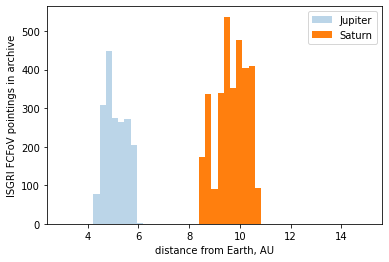

In [314]:
plt.figure()

m = R.Jupiter_from_sc_x_deg < 10
h = plt.hist(
    toau(R.Jupiter_distance_cm)[m],
    alpha=0.3,
    bins=np.linspace(3, 15),
    label="Jupiter"
)

m = R.Saturn_from_sc_x_deg < 10
plt.hist(
    toau(R.Saturn_distance_cm)[m],    
    bins=h[1],
    label="Saturn"
)

plt.ylabel("ISGRI FCFoV pointings in archive")
plt.xlabel("distance from Earth, AU")

plt.legend()

In [281]:
R.Jupiter_distance_cm

0         78941729298709.95
1         78313775145895.27
2         78289429840609.72
3         78265082661944.84
4          78240733684661.8
                ...        
160548    89658584415042.98
160549    89660478219692.66
160550    89662371521250.52
160551    89664262359622.25
160552    89666134110051.08
Name: Jupiter_distance_cm, Length: 160553, dtype: object

In [171]:
import integralclient as ic

ic.converttime("IJD", f"{h[1][i]:.20g}", "UTC")

2021-03-19 16:10:41 savchenk-NG-VN7-793G-79EG root[1743133] INFO url https://www.astro.unige.ch/cdci/astrooda/dispatch-data/gw//timesystem/api/v1.0/converttime/IJD/5048.0480480480473489/UTC


'2013-10-27T01:08:04.167'

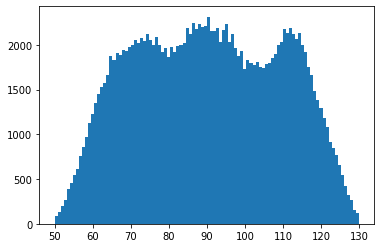

In [515]:
plt.figure()

# the reason why venus is rare is because of solar angle. inner planets have that restriction
# ISGRI has extra 10 deg for off-axis pointing, if designed
# it is never possible to observe Venus
# https://en.wikipedia.org/wiki/Elongation_(astronomy) of venus is up to 47 deg

_=plt.hist(
    Sun_coord.separation(scx_coord).deg,
    100
)

plt.axvline()

the reason why venus is rare is because of solar angle. inner planets have that restriction
ISGRI has extra 10 deg for off-axis pointing, if designed

In [400]:
import json

#json.dump(summary_by_body, open("summary_by_body.json", "wt"), indent=4)

summary_by_body

{'Venus': {'sensitivity_erg_s': 2023918343384943.8,
  'on_isgri_Ms': 0.168514,
  'on_pointings': 81},
 'Sun': {'sensitivity_erg_s': inf, 'on_isgri_Ms': 0.0, 'on_pointings': 0},
 'Mars': {'sensitivity_erg_s': 1151191493617938.0,
  'on_isgri_Ms': 3.744135,
  'on_pointings': 1588},
 'Mercury': {'sensitivity_erg_s': inf, 'on_isgri_Ms': 0.0, 'on_pointings': 0},
 'Jupiter': {'sensitivity_erg_s': 2.182728445837121e+16,
  'on_isgri_Ms': 4.360247,
  'on_pointings': 1853},
 'Saturn': {'sensitivity_erg_s': 6.4927958799684536e+16,
  'on_isgri_Ms': 9.066307,
  'on_pointings': 3207},
 'Uranus': {'sensitivity_erg_s': 1.855665674969776e+18,
  'on_isgri_Ms': 0.17205,
  'on_pointings': 67},
 'Neptune': {'sensitivity_erg_s': 4.746794849613064e+18,
  'on_isgri_Ms': 0.182509,
  'on_pointings': 61},
 'Pluto': {'on_isgri_Ms': 8.682008, 'on_pointings': 3813}}

In [411]:
pd.DataFrame([{'name':k, 'known_typical_lum': reference_object_erg_s.get(k, 0), **v} for k, v in summary_by_body.items()])

,name,known_typical_lum,sensitivity_erg_s,on_isgri_Ms,on_pointings
0,Venus,5.500000e+14,2.023918e+15,0.168514,81
1,Sun,0.000000e+00,inf,0.000000,0
2,Mars,4.000000e+13,1.151191e+15,3.744135,1588
3,Mercury,0.000000e+00,inf,0.000000,0
4,Jupiter,2.200000e+16,2.182728e+16,4.360247,1853
5,Saturn,8.700000e+14,6.492796e+16,9.066307,3207
6,Uranus,6.000000e+15,1.855666e+18,0.172050,67
7,Neptune,1.200000e+16,4.746795e+18,0.182509,61
8,Pluto,2.000000e+15,NaN,8.682008,3813


In [403]:
for o, d in summary_by_body.items():
    print(f"{o}")
    try:
        print(f" : known value {reference_object_erg_s[o]:5.3g} archive 1 sigma limit {d['sensitivity_erg_s']:5.4g} erg/s")
        print(f" : typical known value / 1 sigma limit in archive /  {reference_object_erg_s[o]/d['sensitivity_erg_s']:5.3g}")
        print(f" : potential for exposure improvement (400ks) {0.4/d['on_isgri_Ms']:5.3g}")    
        print(f" : typical known value / ToO limit /  {reference_object_erg_s[o]/(d['sensitivity_erg_s']/(0.4/d['on_isgri_Ms'])**0.5):5.3g}")
    except:
        print("nope")

Venus
 : known value 5.5e+14 archive 1 sigma limit 2.024e+15 erg/s
 : typical known value / 1 sigma limit in archive /  0.272
 : potential for exposure improvement (400ks)  2.37
 : typical known value / ToO limit /  0.419
Sun
nope
Mars
 : known value 4e+13 archive 1 sigma limit 1.151e+15 erg/s
 : typical known value / 1 sigma limit in archive /  0.0347
 : potential for exposure improvement (400ks) 0.107
 : typical known value / ToO limit /  0.0114
Mercury
nope
Jupiter
 : known value 2.2e+16 archive 1 sigma limit 2.183e+16 erg/s
 : typical known value / 1 sigma limit in archive /   1.01
 : potential for exposure improvement (400ks) 0.0917
 : typical known value / ToO limit /  0.305
Saturn
 : known value 8.7e+14 archive 1 sigma limit 6.493e+16 erg/s
 : typical known value / 1 sigma limit in archive /  0.0134
 : potential for exposure improvement (400ks) 0.0441
 : typical known value / ToO limit /  0.00281
Uranus
 : known value 6e+15 archive 1 sigma limit 1.856e+18 erg/s
 : typical known 

In [757]:
R.to_pandas().to_csv("archive-with-bodies.csv.gz", compression='gzip')

In [25]:
import requests
import re
import pandas as pd
import io


t = requests.get("https://heasarc.gsfc.nasa.gov/docs/heasarc/headates/what_kind.html").text
table = re.search("<pre>(.*?)</pre>", t, re.M | re.S).groups()[0]
table = re.sub(" - [0-9]\.[0-9]E[0-9]+? ", " "*8, table).replace("<"," ")
print(table)

d = pd.read_fwf(io.StringIO(table), header=1)
d['Lx_erg_s'] = d['Lx (erg/s)'].astype(float)

reference_object_erg_s = dict(zip(d['Object'], d['Lx_erg_s']))
reference_object_erg_s


Object      Lx (erg/s)        Lx (SI)        Comments

Moon        7.3E11            73 kW
Europa      1.5E13            1.5 MW

Io          2.0E13            2 MW
Mars        4.0E13          4 - 16 MW
Comets      1.0E14          10 - 5000 MW   Within 2 Au of the Sun
Earth       3.0E14            30 MW          My guess
Venus       5.5E14            55 MW
Saturn      8.7E14            87 MW
Io Plasma   1.0E15            100 MW
Torus
Pluto       2.0E15            200 MW         Surprisingly large!
Uranus      6.0E15            600 MW
Neptune     1.2E16           1200 MW
Jupiter     2.2E16           2200 MW



{nan: nan,
 'Moon': 730000000000.0,
 'Europa': 15000000000000.0,
 'Io': 20000000000000.0,
 'Mars': 40000000000000.0,
 'Comets': 100000000000000.0,
 'Earth': 300000000000000.0,
 'Venus': 550000000000000.0,
 'Saturn': 870000000000000.0,
 'Io Plasma': 1000000000000000.0,
 'Torus': nan,
 'Pluto': 2000000000000000.0,
 'Uranus': 6000000000000000.0,
 'Neptune': 1.2e+16,
 'Jupiter': 2.2e+16}

In [206]:
venus_future = get_body_coord_astropy_future('Venus')
Sun_future = get_body_coord_astropy_future('Sun')


In [235]:
m = Sun_future.separation(venus_future).deg > 46

m &= T_future_astropy > time.Time('2022-01-01T00:00:00', format='isot')
m &= T_future_astropy < time.Time('2023-01-01T00:00:00', format='isot')

print(np.sum(m))

venus_future[m]

for t, v in zip(T_future[m], venus_future[m]):
    print(t, v.ra.deg, v.dec.deg)

27
2022-03-08 09:20:14.315988 303.021783660464 -16.520847763919
2022-03-09 09:21:33.292222 303.95860086303185 -16.434855876070955
2022-03-10 09:22:52.268456 304.90443650902296 -16.341369338401794
2022-03-11 09:24:11.244690 305.858814581935 -16.240315593329097
2022-03-12 09:25:30.220924 306.8212773139993 -16.1316316034341
2022-03-13 09:26:49.197158 307.7913845940878 -16.015263626642895
2022-03-14 09:28:08.173392 308.7687134808197 -15.891166955002804
2022-03-15 09:29:27.149626 309.752857678784 -15.75930564528483
2022-03-16 09:30:46.125860 310.7434268364292 -15.619652284910151
2022-03-17 09:32:05.102094 311.74004555233245 -15.47218784720493
2022-03-18 09:33:24.078328 312.74235204417846 -15.316901687950013
2022-03-19 09:34:43.054562 313.7499965408524 -15.153791712959224
2022-03-20 09:36:02.030796 314.76263957754264 -14.982864703697578
2022-03-21 09:37:21.007030 315.7799504600404 -14.804136736955938
2022-03-22 09:38:39.983264 316.801606171397 -14.617633596599587
2022-03-23 09:39:58.959498 3

In [223]:
T_future_astropy > time.Time('2022-01-01T00:00:00', format='isot')

array([False, False, False, ...,  True,  True,  True])